# Geospatial Matching Optimization

This project is designed to showcase how to improve the speed of a polygon matching procedure. There are three main areas that could benefit from taking a "geospatial-native" approach:

1. Data encoding and fetching
2. Matching
3. Storage

We will generate synthetic polygon data and use both a non-geospatial-native and geospatial-native approach, comparing execution time for both to see how they differ.

Note: Make sure that you have PostgreSQL running.

## Imports

In [155]:
import geopandas as gpd
import pandas as pd
import shapely
import h3
import time
import helpers as h
import matplotlib.pyplot as plt
from shapely.wkt import dumps, loads
from pathlib import Path
import psycopg2
from psycopg2 import sql
import psutil

# ensure helpers is loaded correctly
import importlib
importlib.reload(h)

Created fresh logs/sid_2025-02-26_17-04-31_timing_results.csv
Created fresh logs/sid_2025-02-26_17-04-31_timing.log


<module 'helpers' from '/Users/sra/files/projects/matching_optimization/helpers.py'>

## Generate Test Data

In [156]:
# Create two months of blob data
prev_month_blobs = h.generate_random_polygons(n=10000)
curr_month_blobs = h.generate_random_polygons(n=10000)

Function `generate_random_polygons` executed in 0.1515 sec, CPU: 18.00%, Memory: 40.36MB
Function `generate_random_polygons` executed in 0.1255 sec, CPU: 0.00%, Memory: 1.20MB


In [157]:
prev_month_blobs.head()

,geometry,id
0,"POLYGON ((-160.00100 27.83205, -160.00100 29.2...",447b0308-4bb5-4705-ba81-1adb16d8605b
1,"POLYGON ((101.61974 -16.65312, 101.61974 -15.5...",051d62eb-2c6d-4a0b-b910-a586ff50d1e1
2,"POLYGON ((39.76350 -4.43575, 39.76350 -2.65339...",c4daedbd-dc04-4615-84f1-789a4029a1aa
3,"POLYGON ((-103.84635 -53.55717, -103.84635 -52...",fbe11cbe-b982-426e-8edf-54e128d82a28
4,"POLYGON ((-160.98214 4.16004, -160.98214 5.351...",fe627180-c31b-4ab6-962f-50c65f4c47cd


In [158]:
curr_month_blobs.head()

,geometry,id
0,"POLYGON ((43.08879 -77.84748, 43.08879 -76.550...",2a491150-7923-447e-81b0-beea42c53971
1,"POLYGON ((-168.16235 -70.49887, -168.16235 -69...",4fb60fe9-d896-4394-a265-45eba0b64695
2,"POLYGON ((-101.17069 26.82229, -101.17069 28.7...",a5ea32df-8b31-4cca-b5b0-32813b3cf34f
3,"POLYGON ((118.19809 28.99926, 118.19809 30.655...",c8f5a899-c63c-4ac6-9607-1fda258314f0
4,"POLYGON ((-7.35884 -21.20598, -7.35884 -19.744...",89f3ce3b-e9d4-4626-939d-a7b96b048a62


In [159]:
# make data folder
Path('data/').mkdir(exist_ok=True)

# save as geoparquet
prev_month_blobs.to_parquet('data/prev_month_blobs.parquet')
curr_month_blobs.to_parquet('data/curr_month_blobs.parquet')

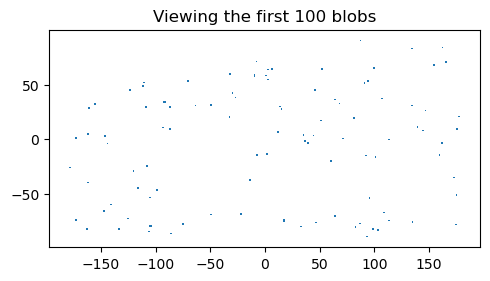

In [160]:
range_ = 100

fig, ax = plt.subplots(figsize=(5, 5))
prev_month_blobs.iloc[0:range_].plot(ax=ax)
ax.set_title(f'Viewing the first {range_} blobs')
plt.tight_layout()

plt.show()

### Make copy of polygon layer and convert to non-geospatial-native string (WKT) datatype

In [161]:
# copy the gdfs
prev_month_blobs_wkt = prev_month_blobs.copy()
curr_month_blobs_wkt = curr_month_blobs.copy()

In [162]:
# Convert WKT versions to strings
dfs_to_convert = [prev_month_blobs_wkt, curr_month_blobs_wkt]
prev_month_blobs_wkt, curr_month_blobs_wkt = [h.convert_col_to_string(df) for df in dfs_to_convert]

# Check result
print(prev_month_blobs_wkt.head())

Function `convert_col_to_string` executed in 0.1237 sec, CPU: 54.30%, Memory: 4.16MB
Function `convert_col_to_string` executed in 0.0487 sec, CPU: 22.20%, Memory: 10.80MB
                                            geometry  \
0  POLYGON ((-160.000995 27.832055, -160.000995 2...   
1  POLYGON ((101.619745 -16.65312, 101.619745 -15...   
2  POLYGON ((39.7635 -4.435747, 39.7635 -2.65339,...   
3  POLYGON ((-103.846347 -53.557165, -103.846347 ...   
4  POLYGON ((-160.982142 4.160037, -160.982142 5....   

                                     id  
0  447b0308-4bb5-4705-ba81-1adb16d8605b  
1  051d62eb-2c6d-4a0b-b910-a586ff50d1e1  
2  c4daedbd-dc04-4615-84f1-789a4029a1aa  
3  fbe11cbe-b982-426e-8edf-54e128d82a28  
4  fe627180-c31b-4ab6-962f-50c65f4c47cd  


/Users/sra/files/projects/matching_optimization/helpers.py:146: UserWarning: Geometry column does not contain geometry.
  
/Users/sra/files/projects/matching_optimization/helpers.py:146: UserWarning: Geometry column does not contain geometry.
  


In [166]:
type(prev_month_blobs_wkt)

list

### Save in PostgreSQL database

1. Set up a PostgreSQL database
2. Store the WKT-version of the blobs (i.e. as strings, not geometry)

In [164]:
# Convert to tuples

prev_month_blobs_wkt = h.df_itertuple(prev_month_blobs_wkt)
curr_month_blobs_wkt = h.df_itertuple(curr_month_blobs_wkt)

Function `df_itertuple` executed in 0.0095 sec, CPU: 46.20%, Memory: 3.36MB
Function `df_itertuple` executed in 0.0031 sec, CPU: 42.90%, Memory: 0.00MB


In [165]:
# Define connection details
postgresql_details = {
    'dbname': 'postgres',  # Use the default database to create the new one
    'user': 'postgres',
    'password': 'rootroot',
    'host': 'localhost',
    'port': '5432'
}

# Step 1: Connect to PostgreSQL and create a new database (if it doesn't exist)
conn = psycopg2.connect(
    dbname=postgresql_details['dbname'],
    user=postgresql_details['user'],
    password=postgresql_details['password'],
    host=postgresql_details['host'],
    port=postgresql_details['port']
)
cur = conn.cursor()

# Commit any active transactions before creating a new database
conn.commit()  # This ensures no open transaction block

# Set autocommit to True for creating the database (it cannot run inside a transaction block)
conn.autocommit = True

# Create a new database (only if it doesn't already exist)
new_db_name = 'blob_matching'
cur.execute(sql.SQL("SELECT 1 FROM pg_database WHERE datname = %s"), [new_db_name])
if not cur.fetchone():
    cur.execute(sql.SQL("CREATE DATABASE {}").format(sql.Identifier(new_db_name)))
    print(f"Database {new_db_name} created.")
else:
    print(f"Database {new_db_name} already exists.")

# Reset autocommit to False (we want to manage transactions for the rest of the operations)
conn.autocommit = False

# Close connection for creating the new database
cur.close()
conn.close()

# Step 2: Connect to the newly created database to create a table
postgresql_details['dbname'] = new_db_name  # Change to the new database
conn = psycopg2.connect(
    dbname=postgresql_details['dbname'],
    user=postgresql_details['user'],
    password=postgresql_details['password'],
    host=postgresql_details['host'],
    port=postgresql_details['port']
)
cur = conn.cursor()

# Create prev_month and curr_month table if it doesn't exist
cur.execute("""
    CREATE EXTENSION IF NOT EXISTS "pgcrypto";
    CREATE TABLE IF NOT EXISTS prev_blobs_wkt (
        geometry TEXT,
        id UUID PRIMARY KEY DEFAULT gen_random_uuid());
    CREATE TABLE IF NOT EXISTS curr_blobs_wkt (
        geometry TEXT,
        id UUID PRIMARY KEY DEFAULT gen_random_uuid());
""")
conn.commit()

# Step 3: Insert WKT strings into the table
cur.executemany('INSERT INTO prev_blobs_wkt (geometry, id) VALUES (%s, %s);', prev_month_blobs_wkt)
cur.executemany('INSERT INTO curr_blobs_wkt (geometry, id) VALUES (%s, %s);', curr_month_blobs_wkt)
conn.commit()

print("Data inserted successfully.")

# Step 4: Retrieve data and convert WKT to geometry
cur.execute("SELECT geometry, id FROM prev_blobs_wkt;")
rows = cur.fetchall()
df_prev = pd.DataFrame(rows, columns=["geometry", "id"])
df_prev["geometry"] = df_prev["geometry"].apply(loads)  # Convert WKT to Shapely geometry
print('df_prev:', df_prev.head())

cur.execute("SELECT geometry, id FROM curr_blobs_wkt;")
rows = cur.fetchall()
df_curr = pd.DataFrame(rows, columns=["geometry", "id"])
df_curr["geometry"] = df_curr["geometry"].apply(loads)  # Convert WKT to Shapely geometry
print('df_curr:', df_curr.head())

# Step 5: Close the connection
cur.close()
conn.close()

Database blob_matching already exists.
Data inserted successfully.
df_prev:                                             geometry  \
0  POLYGON ((-158.5966725744266 26.60522886734023...   
1  POLYGON ((176.21978409511246 -14.9280088021202...   
2  POLYGON ((137.9785558137033 27.41222741599516,...   
3  POLYGON ((-57.580964985751486 23.5397270674304...   
4  POLYGON ((-66.90923725606675 67.10130112202731...   

                                     id  
0  1a954e4a-ccd6-43b4-8a40-0c85055d0174  
1  534f1521-309b-44c2-b4c4-73c1d65f13b6  
2  3dba4ec5-89bc-4a8c-9110-af3937c3ec0b  
3  009b12e8-9002-44fd-b285-06bda955aaf2  
4  09081e2b-cb99-48b5-aa28-8e820ae78bb3  
df_curr:                                             geometry  \
0  POLYGON ((-136.99860799384905 -15.327728065322...   
1  POLYGON ((-88.84855651599074 -65.2365588753379...   
2  POLYGON ((78.38793774218577 22.894964271778974...   
3  POLYGON ((-100.88450978918468 -44.459107566554...   
4  POLYGON ((106.46892154657614 89.44615155659

Baseline - Polygon Matching Only